Using tutorial from Matt https://github.com/mandieq/strava_related/blob/master/stravalib_sample.ipynb
    
SCRAP THAT, tutorial of dreams: https://laptrinhx.com/accessing-user-data-via-the-strava-api-using-stravalib-2725696708/

In [3]:
import time
import pickle
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import folium

pd.set_option("display.max_columns", 100)

In [4]:
from stravalib.client import Client
client = Client()

In [5]:
MY_STRAVA_CLIENT_ID = '47585'
MY_STRAVA_CLIENT_SECRET = '785ef375378211e49fd5b3311e7386b688bb6da0'

In [6]:
url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read_all'])

In [7]:
print(url)

https://www.strava.com/oauth/authorize?client_id=47585&redirect_uri=http%3A%2F%2F127.0.0.1%3A5000%2Fauthorization&approval_prompt=auto&response_type=code&scope=read_all%2Cprofile%3Aread_all%2Cactivity%3Aread_all


In [10]:
CODE = "c607fe7251af043f2f0d392075a9fc78a025fbd1" # not sure i copied this right

In [12]:
access_token = client.exchange_code_for_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, code=CODE)

Fault: 400 Client Error: Bad Request [Bad Request: [{'resource': 'AuthorizationCode', 'field': '', 'code': 'expired'}]]

In [16]:
with open('../access_token.pickle', 'wb') as f:
    pickle.dump(ccess_token, f)

In [17]:
with open('../access_token.pickle', 'rb') as f:
    access_token = pickle.load(f)
    
print('Latest access token read from file:')
access_token

Latest access token read from file:


{'access_token': 'd965ea3178c3e97cd0b027c9a4cd093ba6d7f95d',
 'refresh_token': '26a8d8090393968e3e385b2deb8082fb7a9da1ed',
 'expires_at': 1613089647}

In [20]:
if time.time() > access_token['expires_at']:
    print('Token has expired, will refresh')
    refresh_response = client.refresh_access_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, refresh_token=access_token['refresh_token'])
    access_token = refresh_response
    client.access_token = refresh_response['access_token']
    client.refresh_token = refresh_response['refresh_token']
    client.token_expires_at = refresh_response['expires_at']
        
else:
    print('Token still valid, expires at {}'
          .format(time.strftime("%a, %d %b %Y %H:%M:%S %Z", time.localtime(access_token['expires_at']))))
    client.access_token = access_token['access_token']
    client.refresh_token = access_token['refresh_token']
    client.token_expires_at = access_token['expires_at']

Token still valid, expires at Fri, 12 Feb 2021 00:27:27 GMT


In [21]:
athlete = client.get_athlete()
print("Athlete's name is {} {}, based in {}, {}"
      .format(athlete.firstname, athlete.lastname, athlete.city, athlete.country))

Athlete's name is Imy Younge, based in None, None


In [22]:
activities = client.get_activities(limit=1000)
list(activities)[0:10]

[<Activity id=4749731144 name='Snow walk 2' resource_state=2>,
 <Activity id=4743557858 name='Sun at the beginning' resource_state=2>,
 <Activity id=4734449890 name='Some days just need 20 mins of Beyonce soundtracked Hiit' resource_state=2>,
 <Activity id=4720422603 name='Not friends with jogging today' resource_state=2>,
 <Activity id=4710723765 name='Return to the dino’s 🦕' resource_state=2>,
 <Activity id=4694433078 name='Break from my desk' resource_state=2>,
 <Activity id=4689168180 name='Wednesday Crystal Palace' resource_state=2>,
 <Activity id=4678652275 name='Monday lunch cycle' resource_state=2>,
 <Activity id=4673080404 name='Snow walk' resource_state=2>,
 <Activity id=4668133623 name='Cutty Sark' resource_state=2>]

In [23]:
my_cols =['name',
          'start_date_local',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_heartrate',
          'max_heartrate',
          'start_latitude',
          'start_longitude']

In [24]:
data = []
for activity in activities:
    my_dict = activity.to_dict()
    data.append([activity.id]+[my_dict.get(x) for x in my_cols])
    
# Add id to the beginning of the columns, used when selecting a specific activity
my_cols.insert(0,'id')

In [25]:
df = pd.DataFrame(data, columns=my_cols)

In [26]:
# He then makes all walks in to hikes, I'm skipping that

df['distance_km'] = df['distance']/1e3 # Create a distance in km column

In [29]:
# Convert dates to datetime type
df['start_date_local'] = pd.to_datetime(df['start_date_local'])
# Create a day of the week and month of the year columns
df['day_of_week'] = df['start_date_local'].dt.day_name()
df['month_of_year'] = df['start_date_local'].dt.month
# Convert times to timedeltas
df['moving_time'] = pd.to_timedelta(df['moving_time'])
df['elapsed_time'] = pd.to_timedelta(df['elapsed_time'])
# Convert timings to hours for plotting
df['elapsed_time_hr'] = df['elapsed_time'].astype(int)/3600e9
df['moving_time_hr'] = df['moving_time'].astype(int)/3600e9

In [34]:
df.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latitude,start_longitude,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr
0,4749731144,Snow walk 2,2021-02-07 10:49:37,Walk,6466.8,01:25:19,01:52:53,39.1,50.6,35.4,1.263,2.6,107.4,127.0,51.407639,-0.012136,6.4668,Sunday,2,1.881389,1.421944
1,4743557858,Sun at the beginning,2021-02-06 11:28:51,Ride,16471.3,00:51:55,00:58:42,162.9,111.5,26.1,5.288,10.3,153.7,188.0,51.407523,-0.011840,16.4713,Saturday,2,0.978333,0.865278
2,4734449890,Some days just need 20 mins of Beyonce soundtr...,2021-02-04 17:50:18,Run,2982.9,00:20:21,00:20:28,15.2,50.6,40.1,2.443,4.0,173.7,194.0,51.407655,-0.012007,2.9829,Thursday,2,0.341111,0.339167
3,4720422603,Not friends with jogging today,2021-02-02 07:28:06,Run,4200.9,00:30:22,00:31:07,29.3,64.7,32.3,2.306,6.1,165.4,194.0,51.407555,-0.011922,4.2009,Tuesday,2,0.518611,0.506111
4,4710723765,Return to the dino’s 🦕,2021-01-31 11:07:46,Walk,4442.5,01:05:24,01:18:57,56.8,112.1,56.8,1.132,2.1,100.3,117.0,51.421272,-0.072641,4.4425,Sunday,1,1.315833,1.090000


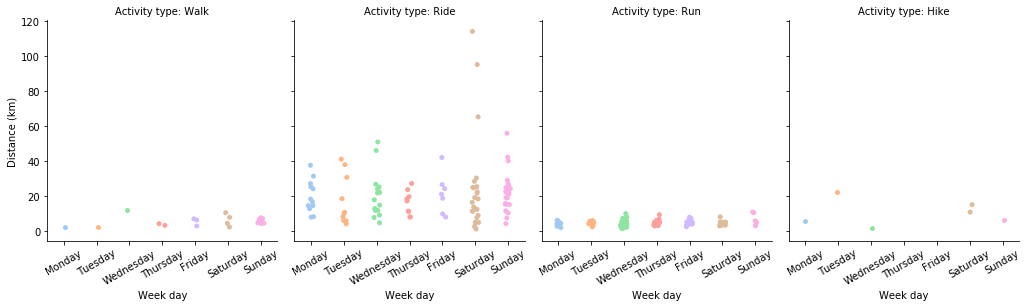

In [32]:
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]

g = sns.catplot(x='day_of_week', y='distance_km', kind='strip', data=df, order=day_of_week_order, col='type', height=4, aspect=0.9, palette='pastel')

(g.set_axis_labels("Week day", "Distance (km)")
  .set_titles("Activity type: {col_name}")
  .set_xticklabels(rotation=30));

In [37]:
# Save to csv so that I can import in to R and analyse there
PATH = '/Users/imytest/Library/Mobile Documents/com~apple~CloudDocs/Documents/Projects_for_fun/Strava/Data/Saves_from_API/'
df.to_csv(f'{PATH}21_Feb_11th.csv')